In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

colours = {
    'lsstu': '#9a0eea', 
    'lsstg': '#75bbfd', 
    'lsstr': '#76ff7b',
    'lssti': '#fdde6c', 
    'lsstz': '#f97306', 
    'lssty': '#e50000'
}

# Central passbands wavelengths
pb_wavelengths = {"lsstu": 3685., "lsstg": 4802., "lsstr": 6231.,
                  "lssti": 7542., "lsstz": 8690., "lssty": 9736.}

In [64]:
data = pd.read_csv("Data/training_set.csv")
data.shape

(1421705, 6)

In [3]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [4]:
def remap_filters(df):  # maybe not in snmachine (raise issue/channel)
    """Function to remap integer filters to the corresponding lsst filters and
    also to set filter name syntax to what snmachine already recognizes

    df: pandas.dataframe
        Dataframe of lightcurve observations
    """
    df.rename({'passband': 'filter'}, axis='columns', inplace=True)
    filter_replace = {0: 'lsstu', 1: 'lsstg', 2: 'lsstr', 3: 'lssti',
                      4: 'lsstz', 5: 'lssty'}
    df['filter'].replace(to_replace=filter_replace, inplace=True)
    return df

In [6]:
data = remap_filters(df = data)
data.rename({'flux_err': 'flux_error'}, axis='columns', inplace=True)  # snmachine and PLAsTiCC uses a different denomination
data.head()

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1


In [7]:
filters = data['filter']
filters = list(np.unique(filters))
filters

['lsstg', 'lssti', 'lsstr', 'lsstu', 'lssty', 'lsstz']

In [8]:
df = data
df.shape

(1421705, 6)

In [9]:
df.head()

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1


In [10]:
object_list = list(np.unique(df['object_id']))
object_list

[615,
 713,
 730,
 745,
 1124,
 1227,
 1598,
 1632,
 1920,
 1926,
 2072,
 2103,
 2300,
 2330,
 2624,
 2677,
 2922,
 3041,
 3285,
 3423,
 3489,
 3910,
 4088,
 4132,
 4171,
 4173,
 4220,
 4389,
 4595,
 4819,
 5527,
 6180,
 6266,
 6762,
 6947,
 7033,
 7164,
 7315,
 7409,
 7566,
 7698,
 7703,
 7756,
 8328,
 8688,
 8745,
 8784,
 9006,
 9172,
 9184,
 9203,
 9543,
 9936,
 9985,
 10321,
 10337,
 10349,
 10478,
 10586,
 10757,
 10796,
 10798,
 11165,
 11359,
 11507,
 11770,
 11773,
 11931,
 11978,
 12695,
 12872,
 13079,
 13138,
 13194,
 13459,
 13482,
 13504,
 14080,
 14156,
 14279,
 14398,
 14539,
 14553,
 14601,
 14674,
 14983,
 15002,
 15251,
 15475,
 15626,
 15674,
 15700,
 15718,
 15845,
 15968,
 16339,
 16349,
 16463,
 16496,
 16802,
 16983,
 17094,
 17172,
 17285,
 17366,
 17370,
 17515,
 18029,
 18507,
 18556,
 18645,
 18706,
 18937,
 18952,
 19154,
 19213,
 19866,
 20567,
 20934,
 21335,
 22184,
 22574,
 22901,
 23116,
 23127,
 23299,
 23373,
 23396,
 23409,
 23539,
 23795,
 23822,
 2

In [11]:
object_list = object_list[:10]
object_list

[615, 713, 730, 745, 1124, 1227, 1598, 1632, 1920, 1926]

In [13]:
def transient_trim(object_list, df):
    adf = pd.DataFrame(data=[], columns=df.columns)
    for obj in object_list:
        obs = df[df['object_id'] == obj]
        obs_time = obs['mjd']
        obs_detected_time = obs_time[obs['detected']==1]
        is_obs_transient = (obs_time > obs_detected_time.iat[0] - 50) & (obs_time < obs_detected_time.iat[-1] + 50)
        obs_transient = obs[is_obs_transient]
        obs_transient['mjd'] -= min(obs_transient['mjd']) # so all transients start at time 0
        adf = np.vstack((adf, obs_transient))
        
    obs_transient = pd.DataFrame(data=adf, columns=obs_transient.columns)
        
    return obs_transient

In [17]:
obs_transient = transient_trim(object_list, df)
print(df.shape)
print(obs_transient.shape)
print( np.unique(obs_transient["object_id"]) )
obs_transient.head()

(1421705, 6)
(1700, 6)
[615 713 730 745 1124 1227 1598 1632 1920 1926]


/tmp/ipykernel_3083636/2312907812.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_transient['mjd'] -= min(obs_transient['mjd']) # so all transients start at time 0


,object_id,mjd,filter,flux,flux_error,detected
0,615,0.0,lsstr,-544.810303,3.622952,1
1,615,0.0077,lsstg,-816.434326,5.55337,1
2,615,0.0154,lssti,-471.385529,3.801213,1
3,615,0.0221,lsstz,-388.984985,11.395031,1
4,615,1.9841,lsstr,-681.858887,4.041204,1


In [18]:
def plot_object(object_name, df, filters):
    for passband in filters:
        data = df[df['object_id'] == object_name]
        data = data[data['filter'] == passband]
        plt.errorbar(x=data['mjd'], y=data['flux'], yerr=data['flux_error'], 
                     linestyle='none', 
                     marker='o', 
                     color=colours[passband]
                    )

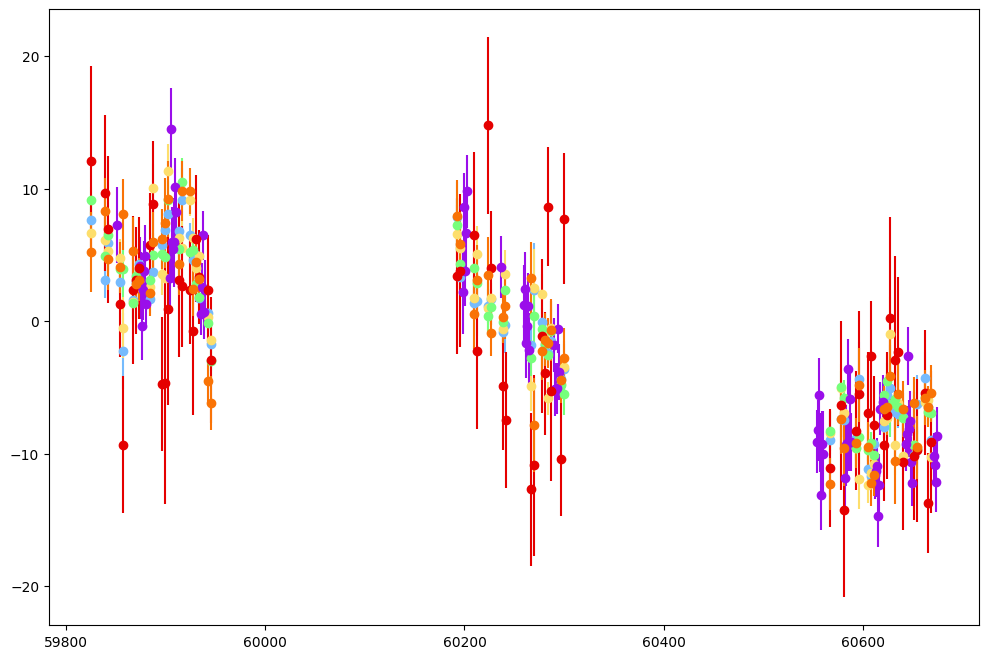

In [20]:
plot_object(713, data, filters)

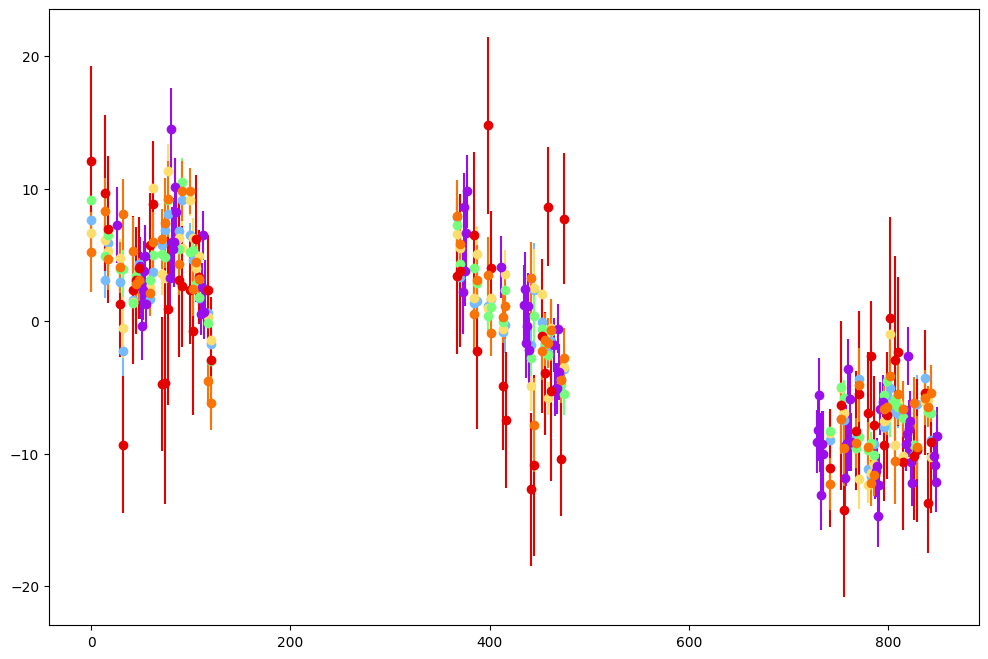

In [21]:
plot_object(713, obs_transient, filters)

In [52]:
data

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,lsstz,-39.881969,46.477093,0
1421701,130779836,60560.0459,lsstg,14.894439,18.947685,0
1421702,130779836,60571.0225,lssty,30.593130,50.695290,0
1421703,130779836,60585.9974,lsstz,-23.471439,44.819859,0


In [51]:
obs_transient

,object_id,mjd,filter,flux,flux_error,detected
0,615,0.0,lsstr,-544.810303,3.622952,1
1,615,0.0077,lsstg,-816.434326,5.55337,1
2,615,0.0154,lssti,-471.385529,3.801213,1
3,615,0.0221,lsstz,-388.984985,11.395031,1
4,615,1.9841,lsstr,-681.858887,4.041204,1
...,...,...,...,...,...,...
1695,1926,494.6611,lsstg,-0.093323,0.915097,0
1696,1926,494.6687,lssti,0.508403,2.171472,0
1697,1926,494.6796,lsstz,0.5574,3.325313,0
1698,1926,494.6906,lssty,-7.179454,8.017539,0


In [41]:
inverse_pb_wavelengths

{3685.0: 'lsstu',
 4802.0: 'lsstg',
 6231.0: 'lsstr',
 7542.0: 'lssti',
 8690.0: 'lsstz',
 9736.0: 'lssty'}

In [23]:
import george
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
import scipy.optimize as op
from functools import partial


def fit_2d_gp(obj_data, return_kernel=False, **kwargs):
    """Fit a 2D Gaussian process.

    If required, predict the GP at evenly spaced points along a light curve.

    Parameters
    ----------
    obj_data : pandas.core.frame.DataFrame or astropy.table.Table
        Time, flux and flux error of the data (specific filter of an object).
    return_kernel : Bool, default = False
        Whether to return the used kernel.
    kwargs : dict
        Additional keyword arguments that are ignored at the moment. We allow
        additional keyword arguments so that the various functions that
        call this one can be called with the same arguments.

    Returns
    -------
    kernel: george.gp.GP.kernel, optional
        The kernel used to fit the GP.
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    """
    guess_length_scale = 20.0  # a parameter of the Matern32Kernel

    #obj_data = preprocess_obs(obj_data, **kwargs)  # preprocess obs

    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    # Use the highest signal-to-noise observation to estimate the scale. We
    # include an error floor so that in the case of very high
    # signal-to-noise observations we pick the maximum flux value.
    signal_to_noises = np.abs(obj_flux) / np.sqrt(
        obj_flux_error ** 2 + (1e-2 * np.max(obj_flux)) ** 2
    )
    scale = np.abs(obj_flux[signal_to_noises.idxmax()])

    kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
        guess_length_scale ** 2, 6000 ** 2], ndim=2)
    kernel.freeze_parameter("k2:metric:log_M_1_1")

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['object_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
import utils, models
import torch.nn.functional as F
import math
import random
import gpytorch
import h5py

print("Is PyTorch using GPU?", torch.cuda.is_available())
device = torch.device("cpu")

training_set = pd.read_csv("Data/training_set.csv")
training_set_metadata = pd.read_csv("Data/training_set_metadata.csv")

print(training_set.shape, training_set_metadata.shape)

# First, extract minimum and maximum times from all the entire data

training_set = pd.read_csv("Data/training_set.csv")
training_set_metadata = pd.read_csv("Data/training_set_metadata.csv")

print(training_set.shape, training_set_metadata.shape)

obj_ids = training_set_metadata["object_id"].values.tolist()

min_times, max_times = [], []

for i in tqdm(range( len(obj_ids) ) ):
	data_obj, label = utils.load_passbands_list(path = "Data/Data_as_h5/obj_passbands.h5", objid = obj_ids[i], path_enter = "Data/")
	min_times.append( float( torch.min( torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 ).flatten() ) ) )
	max_times.append( float( torch.max( torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 ).flatten() ) ) )

general_min, general_max = np.min(min_times), np.max(max_times)

print("Total minimum time: ", general_min)
print("Total maximum time: ", general_max)

/home/toni/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is PyTorch using GPU? True
(1421705, 6) (7848, 12)
(1421705, 6) (7848, 12)


100%|███████████████████████████████████████| 7848/7848 [01:42<00:00, 76.59it/s]

Total minimum time:  59580.03515625
Total maximum time:  60674.36328125


In [25]:
obs_transient_single = obs_transient[obs_transient['object_id'] == 1926]
obs_transient_single.head()

,object_id,mjd,filter,flux,flux_error,detected
1530,1926,0.0,lsstu,3.958863,2.824126,0
1531,1926,0.9127,lsstu,0.466958,2.506363,0
1532,1926,1.915,lsstu,-0.544849,2.526456,0
1533,1926,2.9081,lsstu,-1.983093,2.862726,0
1534,1926,3.9089,lsstu,-7.061294,3.26184,0


In [26]:
gp_predict = fit_2d_gp(obs_transient_single)

In [30]:
number_gp = 100

gp_times = np.linspace(min(obs_transient_single['mjd']), max(obs_transient_single['mjd']), number_gp)
gp_times.shape

(100,)

In [33]:
gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)
gp_wavelengths.shape

(6,)

In [35]:
obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)

In [36]:
inverse_pb_wavelengths = {v: k for k, v in pb_wavelengths.items()}

In [37]:
obj_gps

,mjd,flux,flux_error,filter
0,0.000000,2.399572,2.013764,3685.0
1,5.026880,-3.900630,2.690589,3685.0
2,10.053760,-2.582418,5.246158,3685.0
3,15.080639,-3.469920,8.197209,3685.0
4,20.107519,-2.770464,11.644872,3685.0
...,...,...,...,...
595,477.553581,3.155143,11.187264,9736.0
596,482.580461,1.287239,10.180913,9736.0
597,487.607340,-0.950632,6.280826,9736.0
598,492.634220,-2.763530,4.589265,9736.0


In [42]:
obj_gps['filter'] = obj_gps['filter'].map(inverse_pb_wavelengths)
obj_gps.head()

,mjd,flux,flux_error,filter
0,0.000000,2.399572,2.013764,lsstu
1,5.026880,-3.900630,2.690589,lsstu
2,10.053760,-2.582418,5.246158,lsstu
3,15.080639,-3.469920,8.197209,lsstu
4,20.107519,-2.770464,11.644872,lsstu


In [43]:
# Central passbands wavelengths
pb_wavelengths = {"lsstu": 3685., "lsstg": 4802., "lsstr": 6231.,
                  "lssti": 7542., "lsstz": 8690., "lssty": 9736.}

In [44]:
pb_colors = {'lsstu':'#984ea3', 'lsstg':'#4daf4a', 'lsstr':'#e41a1c', 
             'lssti':'#377eb8', 'lsstz':'#ff7f00', 'lssty':'#e3c530'} # colours for the plot

def plot_real_data_and_model(obj_data, obj_model=None, number_col=2, 
                             show_title=False, show_legend=True):
    f, ax = plt.subplots()

    """Plots real data and model fluxes at the corresponding mjd"""
    passbands = np.unique(obj_data['filter'])
    passbands = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']
    for pb in passbands:
        obj_data_pb = obj_data[obj_data['filter'] == pb] # obj LC in that passband
        if obj_model is not None:
            obj_model_pb = obj_model[obj_model['filter'] == pb]
            model_flux = obj_model_pb['flux']
            ax.plot(obj_model_pb['mjd'], model_flux, color=pb_colors[pb], alpha=.7, label='')
            try:
                model_flux_error = obj_model_pb['flux_error']
                ax.fill_between(x=obj_model_pb['mjd'], y1=model_flux-model_flux_error, 
                                 y2=model_flux+model_flux_error, color=pb_colors[pb], alpha=.15, label=None)
            except:
                pass
        ax.errorbar(obj_data_pb['mjd'], obj_data_pb['flux'], obj_data_pb['flux_error'], 
                     fmt='o', color=pb_colors[pb], label=pb[-1])
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Flux units')
    if show_title:
        ax.title('Object ID: {}\nPhoto-z = {:.3f}'.format(obj_data.meta['name'], obj_data.meta['z']))
    if show_legend:
        ax.legend(ncol=number_col, handletextpad=.3, borderaxespad=.3, 
                   labelspacing=.2, borderpad=.3, columnspacing=.4)
        
    return ax

In [45]:
obs_transient_single

,object_id,mjd,filter,flux,flux_error,detected
1530,1926,0.0,lsstu,3.958863,2.824126,0
1531,1926,0.9127,lsstu,0.466958,2.506363,0
1532,1926,1.915,lsstu,-0.544849,2.526456,0
1533,1926,2.9081,lsstu,-1.983093,2.862726,0
1534,1926,3.9089,lsstu,-7.061294,3.26184,0
...,...,...,...,...,...,...
1695,1926,494.6611,lsstg,-0.093323,0.915097,0
1696,1926,494.6687,lssti,0.508403,2.171472,0
1697,1926,494.6796,lsstz,0.5574,3.325313,0
1698,1926,494.6906,lssty,-7.179454,8.017539,0


In [46]:
obj_gps

,mjd,flux,flux_error,filter
0,0.000000,2.399572,2.013764,lsstu
1,5.026880,-3.900630,2.690589,lsstu
2,10.053760,-2.582418,5.246158,lsstu
3,15.080639,-3.469920,8.197209,lsstu
4,20.107519,-2.770464,11.644872,lsstu
...,...,...,...,...
595,477.553581,3.155143,11.187264,lssty
596,482.580461,1.287239,10.180913,lssty
597,487.607340,-0.950632,6.280826,lssty
598,492.634220,-2.763530,4.589265,lssty


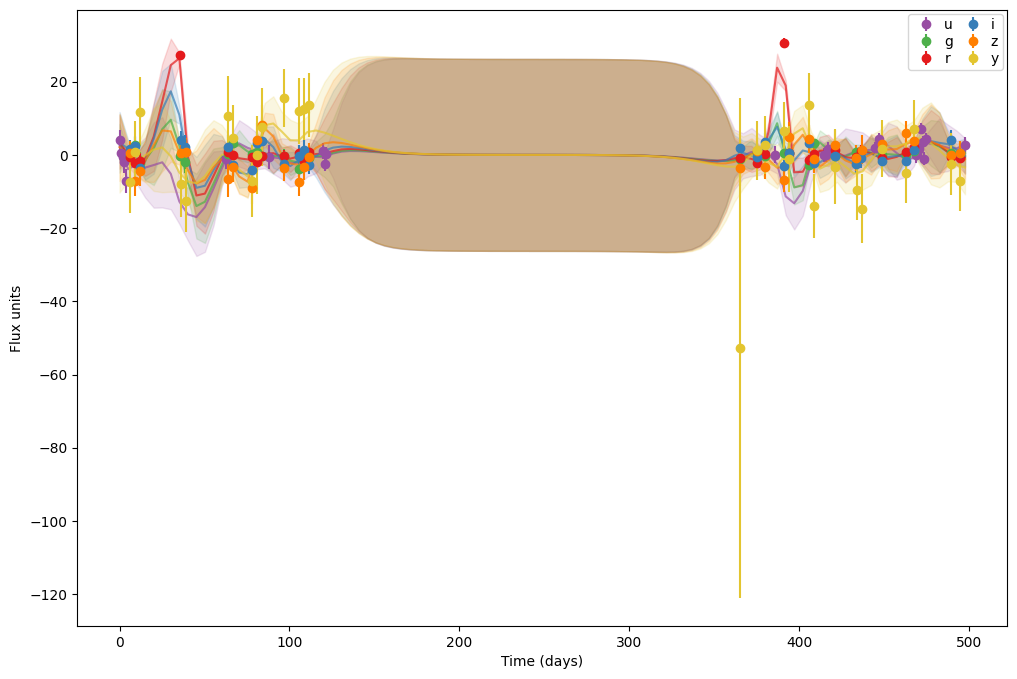

In [47]:
ax = plot_real_data_and_model(obs_transient_single, obj_model=obj_gps)

In [54]:
obs_transient_single = obs_transient[obs_transient['object_id'] == 1926]
obs_transient_single.head()

,object_id,mjd,filter,flux,flux_error,detected
1530,1926,0.0,lsstu,3.958863,2.824126,0
1531,1926,0.9127,lsstu,0.466958,2.506363,0
1532,1926,1.915,lsstu,-0.544849,2.526456,0
1533,1926,2.9081,lsstu,-1.983093,2.862726,0
1534,1926,3.9089,lsstu,-7.061294,3.26184,0


In [55]:
obs_transient_single = data[data['object_id'] == 1926]
obs_transient_single.head()

,object_id,mjd,filter,flux,flux_error,detected
3024,1926,59582.3282,lsstu,3.958863,2.824126,0
3025,1926,59583.2409,lsstu,0.466958,2.506363,0
3026,1926,59584.2432,lsstu,-0.544849,2.526456,0
3027,1926,59585.2363,lsstu,-1.983093,2.862726,0
3028,1926,59586.2371,lsstu,-7.061294,3.261840,0


In [56]:
gp_predict = fit_2d_gp(obs_transient_single)

number_gp = 100

gp_times = np.linspace(min(obs_transient_single['mjd']), max(obs_transient_single['mjd']), number_gp)

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)

inverse_pb_wavelengths = {v: k for k, v in pb_wavelengths.items()}

obj_gps['filter'] = obj_gps['filter'].map(inverse_pb_wavelengths)

# Central passbands wavelengths
pb_wavelengths = {"lsstu": 3685., "lsstg": 4802., "lsstr": 6231.,
                  "lssti": 7542., "lsstz": 8690., "lssty": 9736.}

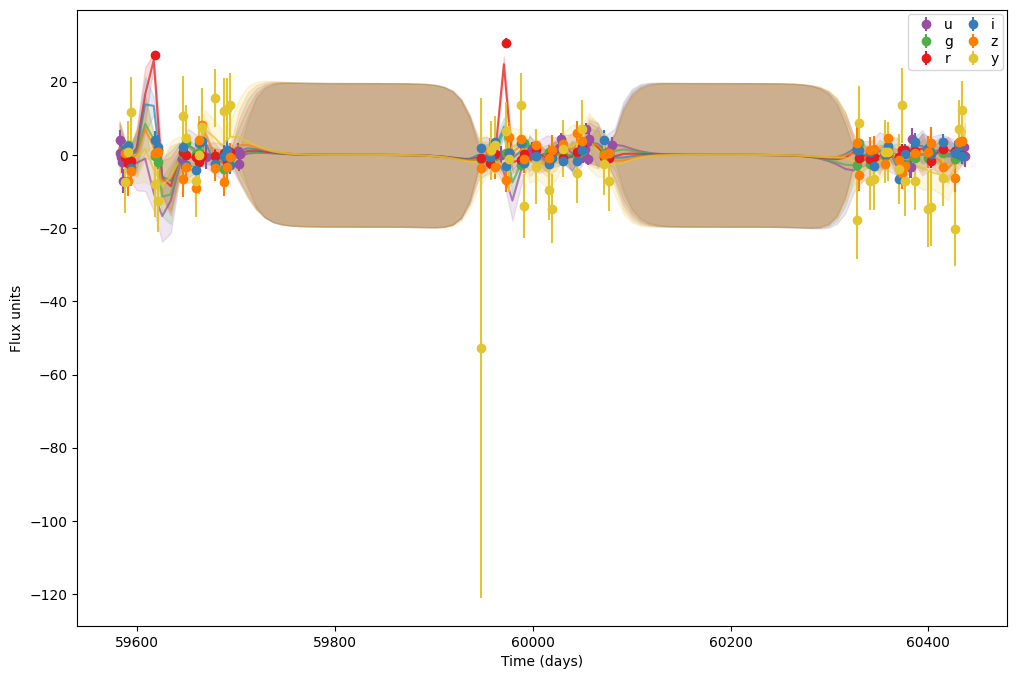

In [57]:
ax = plot_real_data_and_model(obs_transient_single, obj_model=obj_gps)

In [58]:
obs_transient_single

,object_id,mjd,filter,flux,flux_error,detected
3024,1926,59582.3282,lsstu,3.958863,2.824126,0
3025,1926,59583.2409,lsstu,0.466958,2.506363,0
3026,1926,59584.2432,lsstu,-0.544849,2.526456,0
3027,1926,59585.2363,lsstu,-1.983093,2.862726,0
3028,1926,59586.2371,lsstu,-7.061294,3.261840,0
...,...,...,...,...,...,...
3274,1926,60434.0005,lssti,-0.257045,2.255514,0
3275,1926,60434.0115,lsstz,3.779453,3.409752,0
3276,1926,60434.0224,lssty,12.140733,8.024131,0
3277,1926,60435.9857,lsstu,2.224481,2.593787,0


In [59]:
obj_gps

,mjd,flux,flux_error,filter
0,59582.328200,1.812345,1.867120,lsstu
1,59590.961087,-2.534356,3.705957,lsstu
2,59599.593974,-2.189004,7.473233,lsstu
3,59608.226861,-0.998332,8.896760,lsstu
4,59616.859747,-10.383300,4.907640,lsstu
...,...,...,...,...
595,60402.452453,-4.700563,4.391734,lssty
596,60411.085339,-5.293548,5.187610,lssty
597,60419.718226,-7.130984,5.316071,lssty
598,60428.351113,-2.323670,3.986198,lssty


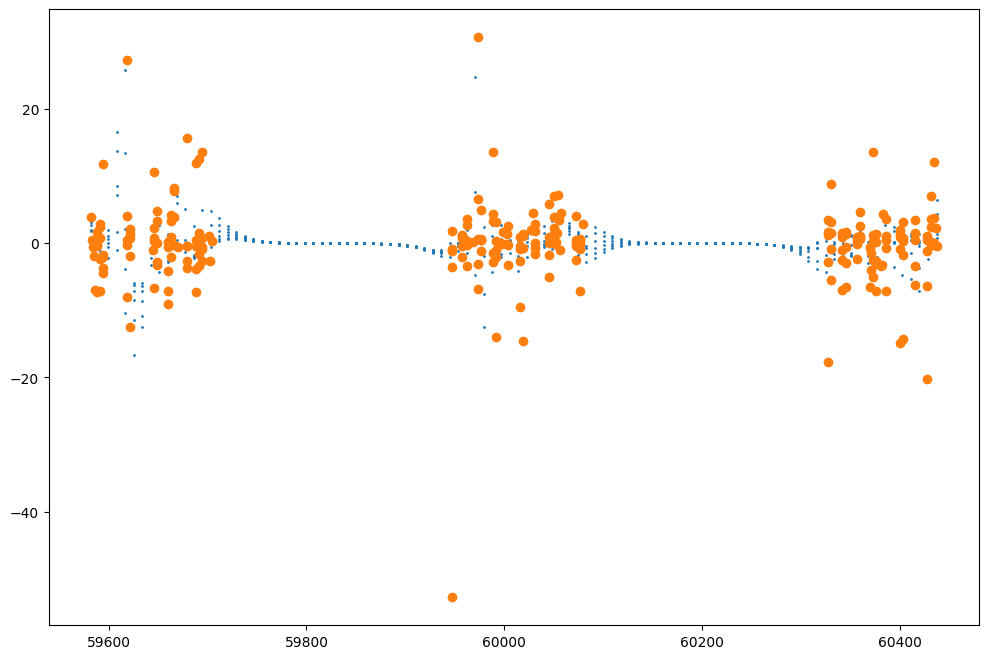

In [61]:
plt.scatter(obj_gps["mjd"], obj_gps["flux"], s = 1)
plt.scatter(obs_transient_single.loc[obs_transient_single["object_id"] == 1926,"mjd"], obs_transient_single.loc[obs_transient_single["object_id"] == 1926,"flux"])

In [63]:
obj_gps

,mjd,flux,flux_error,filter
0,59582.328200,1.812345,1.867120,lsstu
1,59590.961087,-2.534356,3.705957,lsstu
2,59599.593974,-2.189004,7.473233,lsstu
3,59608.226861,-0.998332,8.896760,lsstu
4,59616.859747,-10.383300,4.907640,lsstu
...,...,...,...,...
595,60402.452453,-4.700563,4.391734,lssty
596,60411.085339,-5.293548,5.187610,lssty
597,60419.718226,-7.130984,5.316071,lssty
598,60428.351113,-2.323670,3.986198,lssty
